In [3]:
import pandas as pd
import seaborn as snb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Read the Stamping data from the Excel file
df = pd.read_excel('Raw_Data_v0.xlsx')

In [5]:
df = df.drop(columns=['Ref#','Heat treatment','Other RM/Rivet/part cost (€/Part)','Gross Weight (g)','Other assembled RM/Rivet/part','Heat Treatment cost (€/Part)'])
df['Raw Material'] = df['Raw Material'].str.title()
df = df.fillna('0')


# Columns to encode
columns_to_encode = ['Production', 'Raw Material', 'Raw Material Designation', 'Surface Treatment']
target_column = 'Total cost with amortization (€/part)'

# Mean Encoding
def mean_encode(df, columns, target):
    for col in columns:
        mean_map = df.groupby(col)[target].mean()
        df[col + '_encoded'] = df[col].map(mean_map)
    return df

df = mean_encode(df, columns_to_encode, target_column)

# Drop original categorical columns
df.drop(columns=columns_to_encode, inplace=True)

In [6]:
df

,Annual target quantity,Raw Material Cost (€/kg),Thickness (mm),Part Net Weight (g),Final Raw Material cost (€/Part),Surface Treatment cost (€/Part),Total cost with amortization (€/part),Production_encoded,Raw Material_encoded,Raw Material Designation_encoded,Surface Treatment_encoded
0,1500000.0,9.400663,1.5,3.000,0.035346,0.000000,0.051500,0.030084,0.595537,0.368182,0.195312
1,1000000.0,9.804307,1.6,3.200,0.038595,0.004970,0.058863,0.030084,0.595537,0.368182,0.290730
2,1500000.0,9.804307,1.3,5.107,0.064738,0.006737,0.089343,0.030084,0.595537,0.368182,0.290730
3,1500000.0,9.401325,1.5,3.731,0.042341,0.006184,0.057637,0.030084,0.595537,0.368182,0.290730
4,1500000.0,1.236886,1.5,3.300,0.006726,0.006184,0.018332,0.030084,0.231952,0.013658,0.290730
...,...,...,...,...,...,...,...,...,...,...,...
154,44538.0,9.354414,6.0,0.056,0.799868,0.000000,1.538638,0.630268,0.595537,0.368182,0.195312
155,38260.0,3.689065,2.5,0.034,0.220553,0.000000,0.353694,0.630268,0.231952,0.353694,0.195312
156,13478.0,1.185771,2.0,0.064,0.191041,0.092227,0.648388,0.630268,0.231952,1.409974,1.227207
157,38260.0,1.185771,2.0,0.010,0.025296,0.013175,0.097968,0.630268,0.231952,1.409974,1.227207


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor


Best Parameters: {'depth': 4, 'iterations': 500, 'learning_rate': 0.1}
RMSE: 0.0920
MAE: 0.0487
R² Score: 0.9203


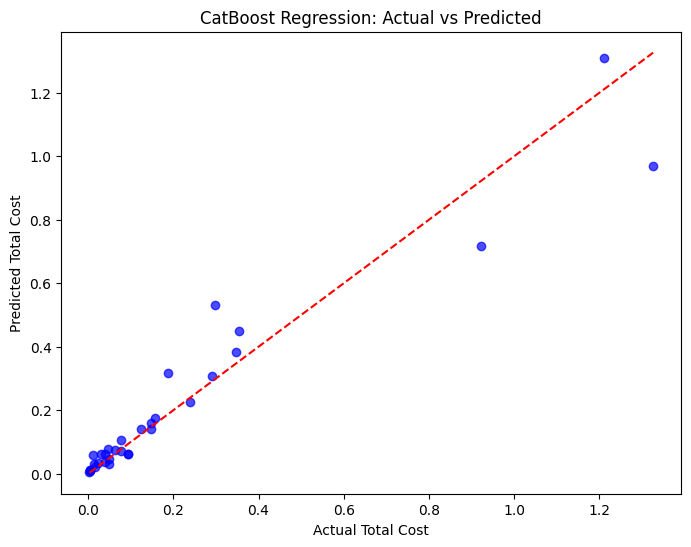

In [20]:
# Define features and target
X = df[['Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)', 'Part Net Weight (g)',
        'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)', 'Production_encoded',
        'Raw Material_encoded', 'Raw Material Designation_encoded', 'Surface Treatment_encoded']]
y = df['Total cost with amortization (€/part)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CatBoost Regressor with hyperparameter tuning
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 300, 500]
}

catboost = CatBoostRegressor(verbose=0)
grid_search = GridSearchCV(catboost, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Total Cost')
plt.ylabel('Predicted Total Cost')
plt.title('CatBoost Regression: Actual vs Predicted')
plt.show()
